In [57]:
from tensorflow.keras import layers,models
import tensorflow_addons as tfa
import tensorflow as tf
from tensorflow import keras
import matplotlib.pylab as plt
import numpy as np
import cv2 
from keras_preprocessing.image import load_img, img_to_array
from tensorflow.keras import *
def Generator():
  inputs = layers.Input(shape=[256, 256, 3])
  down_stack = [
      down_sample(64, 4, apply_instancenorm=False), # (size, 128, 128, 64)
      down_sample(128, 4),                          # (size, 64, 64, 128)
      down_sample(256, 4),                          # (size, 32, 32, 256)
      down_sample(512, 4),                          # (size, 16, 16, 512)
      down_sample(512, 4),                          # (size, 8, 8, 512)
      down_sample(512, 4),                          # (size, 4, 4, 512)
      down_sample(512, 4),                          # (size, 2, 2, 512)
      down_sample(512, 4)                           # (size, 1, 1, 512)
  ]
  up_stack = [
      up_sample(512, 4, apply_dropout=True),  # (size, 2, 2, 1024) : deep = 512 + 512(skip connect)
      up_sample(512, 4, apply_dropout=True),  # (size, 4, 4, 1024)
      up_sample(512, 4, apply_dropout=True),  # (size, 8, 8, 1024)
      up_sample(512, 4),  # (size, 16, 16, 1024)
      up_sample(256, 4),  # (size, 32, 32, 512)
      up_sample(128, 4),  # (size, 64, 64, 256)
      up_sample(64, 4)  # (size, 128, 128, 128)
  ]
  initializer = tf.random_normal_initializer(0., 0.02)
  last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer,
                                activation='tanh')  # (size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
      x = down(x)
      skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
      x = up(x)
      x = layers.Concatenate()([x, skip])

  x = last(x)
  return keras.Model(inputs=inputs, outputs=x)

OUTPUT_CHANNELS = 3
def down_sample(filters, size, apply_instancenorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)
  gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

  layer = keras.Sequential()
  layer.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

  if apply_instancenorm:
    layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))
  layer.add(layers.LeakyReLU())
  return layer

def up_sample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  gamma_init = keras.initializers.RandomNormal(mean=0, stddev=0.02)

  layer = keras.Sequential()
  layer.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
  layer.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

  if apply_dropout:
    layer.add(layers.Dropout(0.5))
  layer.add(layers.ReLU())
  return layer

monet_generator = Generator()
monet_generator.load_weights('ckpt_monet_generator.h5')

# model = models.load_model('/home/innereye/JWST/monet_discriminator.h5')

img=load_img('train\image 28.png',color_mode='rgb',target_size=(256,256),grayscale=False)


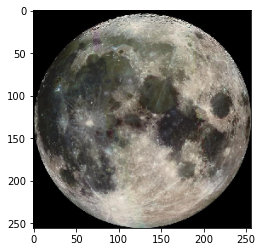

In [73]:
plt.imshow(img)

In [133]:
matrix = img_to_array(img)

In [134]:
mask = matrix >0

In [135]:
mask.shape

(256, 256, 3)

In [136]:
# matrix=matrix.astype('uint8')

In [137]:
matrix = matrix[np.newaxis,:,:,:]

In [138]:
save = monet_generator.predict(matrix/255)
save =np.squeeze(save)

1/1 [==============================] - 0s 214ms/step


In [139]:
save*=mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


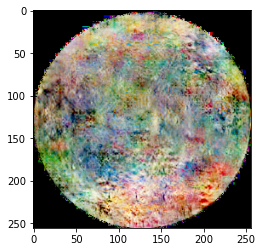

In [140]:
plt.imshow(save)